<a href="https://colab.research.google.com/github/Eyu-148/CS254ML-HW/blob/main/Eyu_Chen_Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7

In this assignment, you will implement back propagatio. You will implement on top of your implemented functions from assignment 6.

In this assignment you will implement the backpropgation algorithm and train the network designed in assignment 6 on the Planar dataset. You will load the data pass it to the network (forward-propagation), calculate the error then pass the error backword to update the weights (back-propagation). You can either implement the SGD, mini-batch or full-batch. maybe the esiest is the full-batch in this case. 

In [1]:
# import the python file from github
# !pip install requests
import requests
url='https://raw.githubusercontent.com/Eyu-148/CS254ML-HW/main/data_utils_for7.py'
r = requests.get(url)
with open('data_utils.py', 'w') as f:
  f.write(r.text)
import data_utils

In [2]:
# import all needed libraries
import numpy as np
import matplotlib.pyplot as plt
from data_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

%matplotlib inline

In [3]:
# Important: Use seed of 0
np.random.seed(0)

In [4]:
#load the data and the features
features, labels = load_planar_dataset()

You are asked to implement the <b>SAME</b> network from assignment 6. You can add your code from assignment 6 (data loading, weight initialization, forward propagation, and computing cost) in the cell below. 

<b>Note: I encourage you to use your solutions from Assignment6. If you want  to have the instructor solutions for assignment-6, please contact the TA but you have to have your assignment 6 submitted.</b>

Here is the network again:

![Network.PNG](attachment:Network.PNG)




In [5]:
def initialize_parameters(input_size, hidden_size, output_size):
    
    """
    input_size-- size of the input layer
    hidden_size -- size of the hidden layer
    output_size-- size of the output layer
    """
    
    Weight1 = np.random.rand(hidden_size, input_size+1) # have the W1 diminsions defined here, the return should be a matrix initalized randomly.  
    Weight2 = np.random.rand(output_size, hidden_size+1) # have the W2 diminsions defined here, the return should be a matrix initalized randomly.
    
    parameters = {'Weight1' : Weight1, 'Weight2' : Weight2}
    
    """
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix 1
                    W2 -- weight matrix 2 
    """
    
    return parameters

In [6]:
def forward_prop(X, parameters):
    """ 
    X -- input data
    parameters -- python dictionary containing your parameters (output of initialization function)
    """
    
    # Retrieve your weights from the "parameters" dictionary
    Weight1 = parameters['Weight1'] 
    Weight2 = parameters['Weight2'] 
    
   # Add bias term to X -> 3*400 matrix
    one = np.ones(X.shape[1])  
    X = np.vstack((one, X))
    
    # Compute pass from layer 1 to layer 2 and activation
    z2 = Weight1.dot(X)
    a2 = np.tanh(z2)
    
    # add bias term to a2
    one = np.ones(a2.shape[1])
    a2  = np.vstack((one, a2))
    
    # Compute pass from layer 2 to layer 3 and activation
    z3 = Weight2.dot(a2)
    a3 = sigmoid(z3)
    
    
    #The values will be needed for the backpropagation which are stored in cache. Later, it will be given to back propagation.
    cache = {"z2": z2,
             "a2": a2,
             "z3": z3,
             "a3": a3}
    """
    Returns:
    a3 -- The sigmoid output of the second activation
    cache -- a dictionary containing "z2", "a2", "z3" and "a3"
    """
    return np.array(a3), cache

In [24]:
def compute_cost(a3, Y):
    
    """
    Computes the cross-entropy cost given in equation (7) or in whichever way you choose.
    
    Arguments:
    a3 -- The sigmoid output of the second activation
    Y -- "true" labels vector of shape 
    """
    m = Y.shape[1]  # number of example
    ones = np.ones(m)

    #print(Y.shape, '\n', a3.shape, '\n', np.log(a3).shape)
    # Compute the cross-entropy cost
    cost = - (np.sum(Y * np.log(a3) + (ones - Y) * (np.log(ones - a3)))) / m

    return cost

## Question 1 - 15 points
Backpropagation is one of the most important parts of training neural networks. The following will implement ONE backpropagation iteration (You can perform full batch updates by feeding all of your samples in X (3x400)). 

Mathematical formula's are given below for your convenience.<br><br>Remember that you need to find the derivative of any weight with respect to the cost function. Then, multiply it with the activation function in order to update using the GD algorithm. The equations below apply to the three-layers network that you are implementing. Where x in $(a^{(x)}, z^{(x)}, W^{(x)})$ refer to the layer number and $dW^{(1)}$ are the gradients from layer 1 and $dW^{(2)}$ are the gradients from layer 2: 

 
 ![bp.PNG](attachment:bp.PNG)
 
<br>Hint:<br>- To compute $\delta^{(2)}$ you'll need to compute $g'(z^{(2)})$.  <br>- Remember that you have two different activation functions, for $\delta^{(2)}$ the activation function is tanh(x).<br>- Derivative of tanh(x) = 1 - $tanh(x)^2$

In [21]:
def backward_propagation(parameters, cache, X, Y):
    """
    parameters -- dictionary containing weights 
    cache -- a dictionary containing "z2", "a2", "z3" and "a3".
    X -- input data
    Y -- "true" labels vector 
    """
    m = X.shape[1]
    
    # Copy W1 and W2 from the dictionary "parameters"
    Weight1 = parameters['Weight1']
    Weight2 = parameters['Weight2']
    
    # Append ones column
    one = np.ones(X.shape[1])
    X = np.vstack((one, X))
    
    # Copy A1 and A2 from dictionary "cache"
    z2 = cache['z2'] 
    a2 = cache['a2'] 
    a3 = cache['a3'] 
    
    #  calculate d3, dW2. Hint: Take a look on how we calculated dW1 and d2 below.
    d3 =  a3 - Y
    dW2 = d3.dot(a2.T)
    
    # Below we will calculate delta 2. In the hidden layer, we have bias which we will exclude for the backprop step.
    # We will be using tanh were as an activation function
    d2 = Weight2.T @ d3
    d2 = d2[1:]
    d2 = d2 * (1 - np.power(np.tanh(z2), 2))
    
    dW1 = d2 @ X.T 
    
    # In the gradient dict we will hold the update for our weight vectors
    gradient = {"dW1": 1/m*dW1,
                "dW2": 1/m*dW2}
    
    return gradient

In [22]:
# Test function for backward propagation
np.random.seed(0) 
X_test = np.random.randn(2, 1)
Y_test = np.random.randn(1, 1)

parameters = {
    'Weight1': 
        np.array([[-0.00416758, -0.00056267,-0.0005612345],
                  [-0.02136196,  0.01640271,0.0005612343],
                  [-0.01793436, -0.00841747,-0.0005612365],
                  [ 0.00502881, -0.01245288,-0.0005211234]]),
    'Weight2': 
        np.array([[-0.01057952, -0.00909008,0.00551432,  0.00551454,  0.02292208]])
}

cache = {
    'z2': np.array([[-0.00616586],
                    [-0.05229879],
                    [-0.02009991],
                    [0.02153007]]),
    'a2': np.array([[1],
                    [-0.05225116],
                    [-0.02009721],
                    [0.02152675],
                    [0.02152675]]),
    'z3': np.array([[ 0.00092281]]),
    'a3': np.array([[ 0.5002307]])  
}

grads = backward_propagation(parameters, cache, X_test, Y_test)

print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))

# Desired Output:

#  dW1 = [[ 0.0043495   0.00767275  0.00174049]
#   [-0.00263144 -0.00464199 -0.00105299]
#   [-0.00263768 -0.00465301 -0.00105549]
#   [-0.0109633  -0.01933983 -0.00438704]]
#  dW2 = [[-0.47850728  0.02500256  0.00961666 -0.01030071 -0.01030071]]

dW1 = [[ 0.0043495   0.00767275  0.00174049]
 [-0.00263144 -0.00464199 -0.00105299]
 [-0.00263768 -0.00465301 -0.00105549]
 [-0.0109633  -0.01933983 -0.00438704]]
dW2 = [[-0.47850728  0.02500256  0.00961666 -0.01030071 -0.01030071]]


### Question 2 - 10 points 
How many parameters you need to train for the network used in this assignment? If one more hidden layer is added to the network with four nerouns, how many parameters you need to train?

We need to train 6 parameters in this assignment. First is the weights, we use backforward method to calculate for 2 weights in each iteration; we also train the 4 activation in the hidden layer as they will be updated as weights change. 

If another hidden layer is added, then we need to train one more weight and four more activations. 

### Question 3 - 15 points 
The update rule will allow you to update the weights and pass the gradients through the network.
Now, Implement the update rule using your known gradients. 

In [11]:
def update_parameters(parameters, grads, learning_rate = 0.5):
    """
    parameters -- dictionary containing network weights 
    grads -- dictionary containing gradients 
    learning_rate -- learning rate for gradient update
    """
    # Copy the following parameter from the dictionary "parameters"
    Weight1 = parameters['Weight1'] 
    Weight2 = parameters['Weight2'] 
     
    # Copy each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    dW2 = grads['dW2']
    
    # Update rule for each parameter. use the vecortized update role.  
    Weight1 -= learning_rate * dW1
    Weight2 -= learning_rate * dW2
    
    parameters = {"Weight1": Weight1,
                  "Weight2": Weight2}
    
    """
    Returns:
    parameters -- dictionary containing updated parameters
    """
    return parameters

In [12]:
# test function update_parameters
np.random.seed(0) 

parameters = {
    'Weight1':
        np.array([[-0.00416758, -0.00056267,-0.00056127],
                  [-0.02136196,  0.01640271,-0.00056123],
                  [-0.01793436, -0.00841747,-0.00036123],
                  [ 0.00502881, -0.01245288,-0.00026117],]),
    'Weight2': 
        np.array([[-0.01057952, -0.00909008,  0.00551454, 0.02292208,0.02292223]])
}

grads = {
    'dW1': 
        np.array([[ 0.00023322, -0.00205423,-0.00205423],
                  [ 0.00082222, -0.00700776,-0.00205423],
                  [-0.00031831,  0.0028636,-0.00205423 ],
                  [-0.00092857,  0.00809933,-0.00205423]]),
    'dW2': 
        np.array([[-1.75740039e-05, 3.70231337e-03, -1.25683095e-03, -2.55715317e-03, -2.55715317e-03]])
}

parameters = update_parameters(parameters, grads)

print("Weight1 = " + str(parameters["Weight1"]))
print("Weight2 = " + str(parameters["Weight2"]))


# Desired Output:

# Weight1 = [[-0.00428419  0.00046445  0.00046585]
#  [-0.02177307  0.01990659  0.00046589]
#  [-0.0177752  -0.00984927  0.00066589]
#  [ 0.00549309 -0.01650255  0.00076595]
# Weight2 = [[-0.01057073 -0.01094124  0.00614296  0.02420066  0.02420081]]

Weight1 = [[-0.00428419  0.00046445  0.00046585]
 [-0.02177307  0.01990659  0.00046589]
 [-0.0177752  -0.00984927  0.00066589]
 [ 0.00549309 -0.01650255  0.00076595]]
Weight2 = [[-0.01057073 -0.01094124  0.00614296  0.02420066  0.02420081]]


### Question 4 - 10 points 

If you initlize the network randomly, are you going to land to the same solution (netwrok parameters (weights)) everytime you train your network in case you trained the network same number of epochs  everytime ? why or why not?

No, initializing the parameters randomly will help to gain accuracy and generalize the model. 

### Question 5 - 20 points 

The mentioned building blocks are now complete. It is time to put it all together. Implement a functioning neural network model given the various functions created above. Note: you might need to define your num_epochs and learning_rate to get it to work.

In [29]:
def model(X, Y, n_h, num_epochs=1000, learning_rate=0.1, print_cost=True):
    """
    X -- dataset
    Y -- labels
    n_h -- size of the hidden layer
    learning_rate=the learning rate you are choosing,
    num_epochs -- Number of iterations in gradient descent
    print_cost -- if True, print the cost in every 100 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    n_x = X.shape[0]
    n_y = len(np.unique(Y))
    
    if n_y <= 2:
        n_y = 1
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    Weight1 = parameters['Weight1']
    Weight2 = parameters['Weight2']
    
    # gradient descent
    for i in range(num_epochs+1):
         
        # Call the Forward propagation with X, and parameters.
        a3, cache = forward_prop(X, parameters)
        
        # Call the Cost function with a3, Y and parameters.
        cost = compute_cost(a3, Y)
        
        # Call Backpropagation with Inputs, parameters, cache, X and Y.
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Update gradient descent parameter with  parameters and grads and learning rate.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 1000 iterations
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        

    return parameters

### Question 6 -- 15 points

Now, you have the model in your hand.It is time to use it and see it in action. Use the model to predict  using the function named predict and also plot the decision boundary. Comment on the results and explain if they make sense or not?

Hint:Use forward propagation to predict results.


In [27]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    parameters -- dictionary containing your weights 
    X -- input data
    
    Returns
    predictions -- vector of model predictions (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation from assignment 6, 
    # classifies to 0/1 using 0.5 as the threshold.
    a3, cache = forward_prop(X, parameters)
    predictions = (a3 > 0.5)
    return predictions

Cost after iteration 0: 0.985170
Cost after iteration 1000: 0.588929
Cost after iteration 2000: 0.346101
Cost after iteration 3000: 0.321096
Cost after iteration 4000: 0.310497
Cost after iteration 5000: 0.303995
Cost after iteration 6000: 0.299227
Cost after iteration 7000: 0.295137
Cost after iteration 8000: 0.289939
Cost after iteration 9000: 0.282405
Cost after iteration 10000: 0.274830
Cost after iteration 11000: 0.268658
Cost after iteration 12000: 0.263757
Cost after iteration 13000: 0.259787
Cost after iteration 14000: 0.256493
Cost after iteration 15000: 0.253702


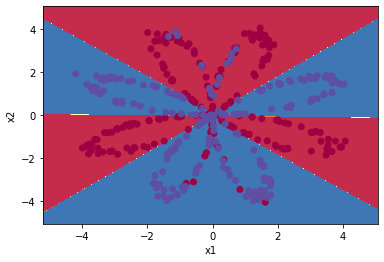

In [28]:
# Build a model with a n_h-dimensional hidden layers
parameters = model(features, labels, 4, 15000)
# plot the decision boundary
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

### Question 7 -- 15 points

If the input to the network all zeros (remember that the bias must still 1), is the output will be all zeros? why or why not?

The answer should be no. As we have bias term in each layer, the output cannot be zeros. 

# Grad Student or Undergrad Extra Credit

### Question 8 -- 15 points

Try out several models of different hidden layer size (different number of neurons) to see how this hyper-parameter effects accuracy.

We try the size of hidden layer in 8, 16, 32, 64, and the decision boundary implies an overfitting occurs. 

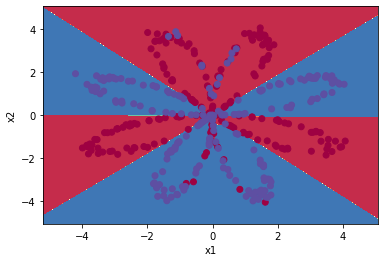

In [34]:
# try different hidden layer size of 8, 16, 32, 64, 128 
parameters = model(features, labels, 8, 15000)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

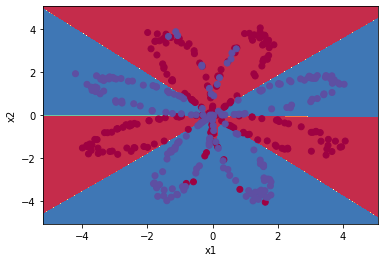

In [35]:
parameters = model(features, labels, 16, 15000)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

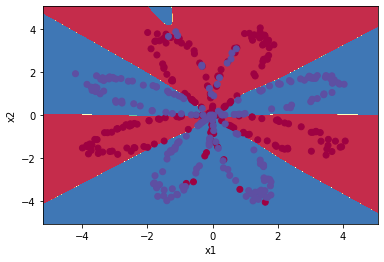

In [36]:
parameters = model(features, labels, 32, 15000)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

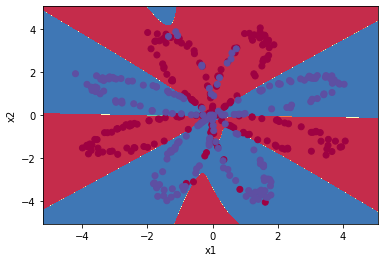

In [33]:
parameters = model(features, labels, 64, 15000)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

### Question 9 -- 5 points
Play with the learning_rate and explain how this changes performance.


The original learning rate of 0.1 gives a nice diecsion boundary and then try 0.01, 0.001 and 0.0001. As the learning rate decreases or increases, the algorithm might be unable to go closer to the convergence, which can cause an underfitting. 

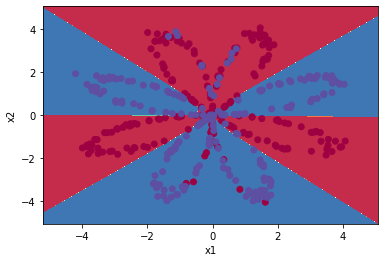

In [37]:
parameters = model(features, labels, 4, 15000, 0.01, print_cost=False)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

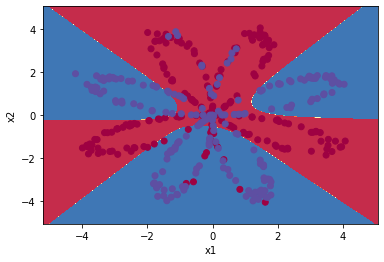

In [38]:
parameters = model(features, labels, 4, 15000, 0.001, print_cost=False)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

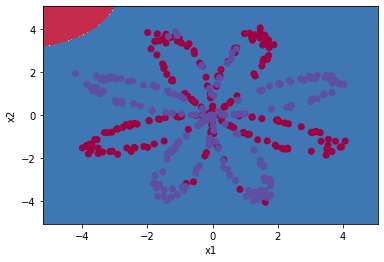

In [41]:
parameters = model(features, labels, 4, 15000, 0.0001, print_cost=False)
plot_decision_boundary(lambda X: predict(parameters, X.T), features, labels.ravel())

### Question 10 -- 5 points

Do you think that the model is overfitting? explain your answer?

No. With a learning rate of 0.1 and a size of 4 for hudden layer, the model appropriately predict and plot the decision boundary with violations in an acceptable number. However, if the size of hidden layer increases, it becomes overfitting on training set; and with lower learning rate, it turns into underfitting. 